In [1]:
#Libraries
%matplotlib inline
import numpy as np
import cmath
import scipy.sparse as sparse
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import locale
import pylab
import random
from scipy.optimize import curve_fit
from scipy import optimize
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import itertools
from scipy.misc import derivative
from scipy.interpolate import UnivariateSpline
from scipy.sparse import diags
# import findiff
# This is needed to use local settings to write point or comma as decimal separator in output files
_locale_radix = locale.localeconv()['decimal_point']

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')

We diagonalize the three junctsions qubit from Orlando, Mooij, ... Mazo PRB 1999. There are two independent fluxes:
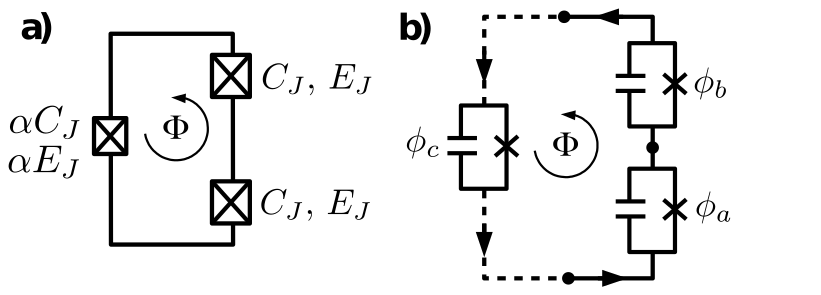

The Hamiltonian in the phases $\phi_a$ and $\phi_b$ is:
$$H= \frac{1+\alpha}{2 C(1+2\alpha)}(q_a^2+q_b^2)-\frac{1}{C(1+2\alpha)}q_a q_b-E_j[\cos(\phi_a)+\cos(\phi_b)+\alpha\cos(\Phi+\phi_a+\phi_b)]$$

The Hamiltonian using variables $\phi_{\pm}= \phi_a\pm\phi_b$ is:
    $$H = \frac{1}{C(1+2\alpha)}q_+^2+\frac{1}{C}q_{-}^2-E_j[\cos\left(\frac{\phi_-}{2}\right)\cos\left(\frac{\phi_+}{2}\right)+\alpha\cos(\Phi+\phi_+)]$$

We can write Hamiltonians using conjugate variables for charge and phase:
$$\left|q\right\rangle = \int d\phi\ e^{i\hat{\phi}\ q}\left|\phi\right\rangle$$
$$\cos(a +\hat{\phi})\left|q\right\rangle = \frac{1}{2}\left(\ e^{i a}\left|q+1\right\rangle+e^{-ia}\left|q-1\right\rangle\ \right)$$

In the following we omit the hat to represent operators.

We have Hamiltonians in the charge bases:

$$ H = \frac{1+\alpha}{C(1+2\alpha)}(q_a^2+q_b^2)-\frac{2}{C(1+2\alpha)}q_a q_b -\frac{E_j}{2}
\left[
\sum_{q_a} \big( \left|q_a+1\right\rangle +\left|q_a-1\right\rangle \big)\langle q_a |
+\sum_{q_b} \big(\left|q_b+1\right\rangle +\left|q_b-1\right\rangle\big)\langle q_b |
+\sum_{q_a,q_b} \left( e^{i\phi}\left|q_a+1,q_b+1\right\rangle +e^{-i\phi}\left|q_a-1,q_b-1\right\rangle\right)\langle q_a,q_b |
\right]$$

Using the other set of conjugate variables:
$$H = \frac{1}{C(1+2\alpha)}q_+^2+\frac{1}{C}q_{-}^2-E_j
\Big[
\sum_{q_+,q_-}  
\bigl( 
\left|q_+ +1,q_- +1\right\rangle +\left|q_+ +1,q_- -1\right\rangle
\left|q_+ -1,q_- +1\right\rangle +\left|q_+ -1,q_- -1\right\rangle
\bigr)\langle q_+,q_- |
+\frac{\alpha}{2}\sum_{q_+} \left( e^{i\phi}\left|q_+ +1\right\rangle +e^{-i\phi}\left|q_+-1\right\rangle\right)\langle q_+ |
\Big]$$


# Define a class with following opeators:

We define clase qubit which contains the bsaic operators needed to perform this diagonalizations. We take an odd $nc$ as the number of charges in each superconducting island. We can write Hamiltonians once we have expressions for these operators:

Charge operator is always diagonal:
$$ \hat{q} = 
  \begin{pmatrix}
    -\frac{nc}{2} & 0 & \dots & \dots & 0 \\
    0 & -\frac{nc}{2}+1 & \dots & \dots & 0 \\
    \vdots & \vdots &  \ddots & \dots & \vdots \\
        \vdots & \vdots & \dots & \frac{nc}{2}-1 & \vdots \\
    0 & 0 & \dots & \dots & \frac{nc}{2}
  \end{pmatrix}
$$
The exponential of flux operators are
$$ e^{-i\hat{\phi}} = 
  \begin{pmatrix}
    0 & 1 & 0 & \dots & 0 \\
    0 & 0 & 1 & \dots & 0 \\
    \vdots & \vdots & \vdots &  \ddots & \vdots \\
        \vdots & \vdots &  \vdots &  0& 1 \\
    0 & 0 & \dots & 0 & 0
  \end{pmatrix}
$$

$$ e^{i\hat{\phi}} = 
  \begin{pmatrix}
    0 & 0 & 0 & \dots & 0 \\
    1 & 0 & 0 & \dots & 0 \\
    \vdots & \ddots  & \vdots &  \vdots & \vdots \\
        \vdots & \vdots &  1 &  0& 0 \\
    0 & 0 & \dots & 1 & 0
  \end{pmatrix}
$$

Then, we can construct operator $\cos(\Phi+\phi_1+\phi_2)$ using the above matrices. This cos operator is defined in function scos(list, c), where list is a sum of the qubit index to be summed and c is a constant.

Now we define a class that implement all these operators in a space with several qubits. Each qubit can have a different Hilbert space dimension. That is because in more difficult problem, where diagonalization is expensive, it may worth to reduce Hilbert space in island wher we know that are more "charge" ($Ec<E_j$) than "flux" ($E_j>E_c$).

Begingn with Hamiltonian in bases $\phi_a, \phi_b$. Units are:

$$E_c =\frac{e^2}{2C}$$
$$q = 2e n$$
where opeators $n$ and $\phi$ are conjugate variables. We use dimensions in Hamiltonian $H/E_c$, so:

$$H/E_c= \frac{4(1+\alpha)}{(1+2\alpha)}(n_a^2+n_b^2)-\frac{8}{1+2\alpha}n_a n_b-E_j[\cos(\phi_a)+\cos(\phi_b)+\alpha\cos(\Phi+\phi_a+\phi_b)]$$

In [3]:
class qubits:
    #
    # nc is a np.array with the maximum number of cooper pairs allowed for each charge. 
    # Thus, the Hilbert space dimension of each qubit is 2*nc[i]+1  
    # 
    def __init__(self, nc):
        # the number of variable characterized by phase and charge:
        self.nc = nc
        self.nd = 2*nc+1
        self.nv = len(nc) 
        self.nh = np.prod(self.nd)
        # qubit operators
        diagonals = [np.linspace(-self.nc[i],self.nc[i],self.nd[i]) for i in range(self.nv) ]
        q = [diags(diagonals[i],0) for i in range(self.nv)]
        q2 = [diags(np.power(diagonals[i],2),0) for i in range(self.nv)]
        diagonals_2 =  [np.ones(self.nd[i]-1) for i in range(self.nv) ]        
        expp = [diags(diagonals_2[i], -1) for i in range(self.nv)]
        expm = [diags(diagonals_2[i], +1) for i in range(self.nv)]
        self.q = [self.spin_operator(q[i],i) for i in range(self.nv)]
        self.q2 = [self.spin_operator(q2[i],i) for i in range(self.nv)]
        self.expp = [self.spin_operator(expp[i],i) for i in range(self.nv)]        
        self.expm = [self.spin_operator(expm[i],i) for i in range(self.nv)]                
    # Methods to promote operators so that they act on the combined
    # Hilbert space of spins. The space has size product(self.nd[i] for i in range(self.nv))
    # Remember python labels every array from index 0.
    def spin_operator(self, op, q_index):
        # Identities to the left of the spin
        sumL = np.prod(np.array(self.nd[:q_index]))
        sumR = np.prod(np.array(self.nd[q_index+1:]))
        Ileft = sparse.eye(sumL)
        # Identities to the right of the spin (some spins and bosons)
        Iright = sparse.eye(sumR)
        # Combined
        return sparse.kron(Ileft, sparse.kron(op, Iright))    
    # This construct cos of operators. 
    # WARNING:
    # Take care with this construction as it is inneficient in memory.
    # I could have contructed everything starting from single particle operators and construct kronencker,
    # instead of multypliying all opearators in full space.
    def scos(self, indx, c):
        # Identities to the left of the spin
        if isinstance(indx, list):
            x = 0.5* \
            (cmath.exp(c*1j)* np.prod(np.array(self.expp)[indx[:]]) + cmath.exp(-c*1j) \
             * np.prod( np.array(self.expm)[indx[:]]) )
        else:
            x = 0.5* (cmath.exp(c*1j)* self.expp[indx]+cmath.exp(-c*1j)* self.expm[indx])
        return x
    # Return the sparse matrix for a Hamiltonian with the given parameters
    # p[0:2] contains alpha, Ej/Ec and flux threading the loop.
    def hamiltonian2q(self,p):
        a1 = 4*(1+p[0])/(1+2*p[0])
        a2 = 8*p[0]/(1+2*p[0])
        A = a1 * (self.q2[0] +self.q2[1]) - a2 * self.q[0] * self.q[1]  \
             - p[1] * (-(2+p[0])*np.identity(self.nh)+self.scos(0,0)+self.scos(1,0)+ p[0] * self.scos([0,1],p[2]) )
        return A
    # Eigensolver for the k lowest states. Take care in the symetric
    # phase to use an even number for k.  For k odd and in the
    # symetric phase, last eigenstate may have convergence issues.
    # Eigensolver is based on Lanczos: it efficeintly computes a few
    # eigenstates of sparse matrix.  For n=3 problem, it cannot
    # compute the whole spectrum. 
    def lowest_states(self,alpha, Ej, phi, k=6):              
        H = self.hamiltonian2q([alpha,Ej,phi])
#         print(H.toarray())
        # SA for smallest algebraic. Look documentation of Arpack
        eie,eiv = sparse.linalg.eigsh(H, k, which='SA')
        return eie, eiv;

In [4]:
# The following is a subroutine to switch between slepc and scipy eigensolvers. It does work for real matrices but
# not for complex one. I need to compile Petsc library with the correct option to allow complex numbers in slepc4y.

In [5]:
# def diagonaliza_slepc(Hp, nv, slepc= True):
#     shape = Hp.shape
#     n = shape[0]
#     if slepc:
#         import slepc4py
#         from petsc4py import PETSc
#         from slepc4py import SLEPc
#         #
#         p1 = Hp.indptr
#         p2 = Hp.indices
#         p3 = Hp.data
#         # COMM_SELF indicates that each processor owns its own matrix. This shodl be changed
#         # when allowing parralelization in the solver. By default, wihtout comm= , the vectors
#         # are diveded between all the proccesors and getOwnershipRange gives the range of the matrix
#         # owned by a given processor.
#         A = PETSc.Mat().createAIJ(size=Hp.shape,csr=(p1,p2,p3),comm=PETSc.COMM_SELF)
#         E = SLEPc.EPS(); E.create()
#         print(E)
#         E.setOperators(A)
#         E.setProblemType(SLEPc.EPS.ProblemType.HEP)
#         E.setDimensions(nev=nv)
#         E.setTolerances( tol=1e-14)                   
#         E.solve()
#         nconv = E.getConverged()
#         print(nconv)
#         if nconv >= nv:
#             # Create the results vectors
#             eie = np.zeros(nv)
#             eiv = np.zeros((n,nv))                            
#             vr, wr = A.getVecs()
#             #
#             for i in range(nv):
#                 k = E.getEigenpair(i, vr)
#                 eie[i] = k.real
#                 eiv[:,i] = vr[:]
# #                 error = E.computeError(i)

#     else:
#         H = Hp
#         eie,eiv = sparse.linalg.eigsh(Hp, nv, which='SA')            
#     return eie,eiv

In [6]:
# nc = np.array([1,1])
# A = qubits(np.array(nc))

# Ej = 80
# alpha =0.8
# flux = np.pi

# H = A.hamiltonian2q([flux,Ej,phi])
# print(H)
# Hs = sparse.csr_matrix(H.real)
# eie, eiv = diagonaliza(Hs, 2,  slepc= True)
# print(eie)
# eie, eiv = diagonaliza(Hs, 2, slepc= False)
# print(eie/Ej)

In [7]:
# Example to solve one problem with Ej=80 and alpha=0.8 

In [14]:
nc = np.array([10,10])
A = qubits(np.array(nc))

Ej = 80
alpha =0.8

flux = np.pi*(1+np.linspace(-0.1,0.1,50))


In [15]:
# Solving many problems for fluxes in between -0.1,0.1

In [16]:
nc = np.array([10,10])
A = qubits(np.array(nc))

Ej = 80
alpha =0.8

flux = np.pi*(1+np.linspace(-0.1,0.1,20))
res = [A.lowest_states(alpha,Ej,a) for a in flux]

lev = np.array([res[i][0] for i in range(len(res))])/Ej

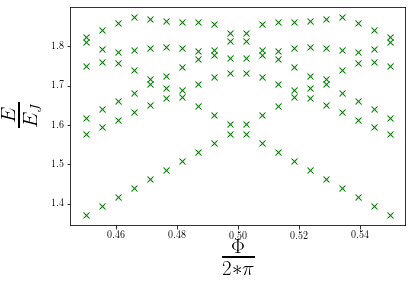

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(flux/(2*np.pi), lev[:,0:], "x",color="green")
ax1.set_xlabel("$\\frac{\Phi}{2*\pi}$", fontsize=30)
ax1.set_ylabel("$\\frac{E}{E_J}$", fontsize=30)
plt.savefig("qbit_3j",bbox_inches='tight')

# One qubit:

First, we develop subroutine to treat the 1 qubit case. The two following are for approximating energy gap using WKB:

In [18]:
# This subroutine would compute the action for a given potential U, mass M, ground-state energy Egs
# and position of the minimum potential x_m.
def s_act(U, M, E_gs, x_m): 
    # f function is the potential energy minus the energy of the ground state which is omega/2+U(x_min)
    f = lambda x: U(x)-(E_gs/2+U(x_m))
    x1 = optimize.root_scalar(f, bracket=[-x_m,0], method='brentq',maxiter=10000)
    fint = lambda x: np.sqrt(f(x))
    yint = 2*integrate.quad(fint, x1.root, 0)[0]
    res = np.sqrt(2*M)*yint
    return res

In [19]:
# E_wkb_1q computes 2 times the tunneling amplitudes for a 3JJ qubits with potentials on top
# It uses WKB formula, as in Bhattacharya PRA 1985. 
# Inputs: a is alpha ration between small and large junctions, Ej and Ec are Josephson and charging energies,
# g is related with capacitors to top potentials as in Orlando PRB 1999, Fig1.
# M should be in units of \hbar^2
def E_wkb_1q(a,g,Ej,Ec):
    x_m = np.arccos(1/(2*a))
    U = lambda x: Ej*(-2*np.cos(x)+a*np.cos(2*x))
    M = (1+2*a+g)/(4*Ec)         
#     Mp = (1+2*a)/(4*Ec)
    E_gs = np.sqrt(derivative(U, x_m, dx=1e-6, n=2)/M)
#     E_p = 2/np.sqrt(a)*np.sqrt(Ej*Ec)
#     Egs_wkb = E_gs + E_p
    res = np.exp(-s_act(U, M, E_gs, x_m))*E_gs/np.pi 
    return res

The subroutines for approximating energy gap with harmonic approximations:

In [20]:
# Inputs: a is alpha ration between small and large junctions, Ej and Ec are Josephson and charging energies,
# m is related with capacitors to top potentials as in Orlando PRB 1999, Fig1.
def gaph(a,m,Ej,Ec):
    phi_s = lambda x: np.arccos(1/(2*x))
    sigma2 = np.sqrt(a/( (4*a**2-1) * (1+2*a+m))) *np.sqrt(Ec/Ej)
    M = (1+2*a+m)/(4*Ec)         
    gap = -2*np.exp(-phi_s(a)**2/(2*sigma2)) * ( 1/(8*sigma2*M) 
                                                *(1-phi_s(a)**2/(2*sigma2))
                                                -Ej*(2*np.exp(-sigma2/2)-a*np.exp(-2*sigma2)) )
    return gap

We compare these two subroutines with result of exact diagonalization:

In [77]:
Ej = 50
alpha =0.7
Ec=1


nc = np.array([20,20])
A = qubits(np.array(nc))



alpha_mine = np.linspace(0.5,1.5,40)
gap_mine =[]
flux = np.pi

for alpha in alpha_mine:
    eie, eiv = A.lowest_states(alpha,Ej,flux, k=2)
    gap_mine.append(np.array([(eie[1]-eie[0])/Ej]))
    print(alpha,gap_mine[-1])

0.5 [0.10744609]
0.5256410256410257 [0.09533699]
0.5512820512820513 [0.08337515]
0.5769230769230769 [0.0716499]
0.6025641025641025 [0.06029449]
0.6282051282051282 [0.0494922]
0.6538461538461539 [0.03947253]
0.6794871794871795 [0.0304878]
0.7051282051282051 [0.02276467]
0.7307692307692307 [0.01644105]
0.7564102564102564 [0.01152005]
0.782051282051282 [0.0078715]
0.8076923076923077 [0.00527911]
0.8333333333333333 [0.00350186]
0.858974358974359 [-0.00231961]
0.8846153846153846 [0.00155422]
0.9102564102564102 [0.00107246]
0.9358974358974359 [-0.00077977]
0.9615384615384615 [-0.00061145]
0.9871794871794872 [-0.00052435]
1.0128205128205128 [-0.00049024]
1.0384615384615383 [0.00049091]
1.064102564102564 [-0.00051472]
1.0897435897435899 [-0.00055433]
1.1153846153846154 [0.00060511]
1.141025641025641 [-0.00066414]
1.1666666666666665 [0.00072959]
1.1923076923076923 [0.00080029]
1.217948717948718 [-0.00087549]
1.2435897435897436 [-0.0009547]
1.2692307692307692 [-0.00103758]
1.2948717948717947 [-0

We plot exact diago, WKB and harmonic approximation:

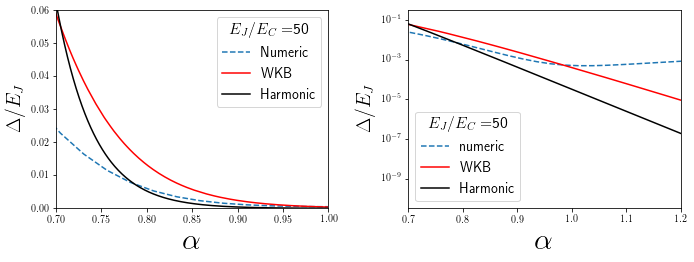

In [78]:
a = alpha
m = 0.0
# Ej 
Ec=1


# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
xx = np.linspace(0.7,1.5,1000)
ywkb = np.array([E_wkb_1q(x,0,Ej,Ec) for x in xx]) 
yh = np.array([gaph(x,0,Ej,Ec) for x in xx]) 

ax1[0].plot(alpha_mine, np.abs(gap_mine),"--", label = "Numeric")
ax1[0].plot(xx, ywkb/Ej, label = "WKB", color = "r")
ax1[0].plot(xx, yh/Ej, label = "Harmonic", color = "black")
ax1[0].set_ylabel("$\Delta/E_J$", fontsize=20)
ax1[0].set_xlabel("$\\alpha$", fontsize=30)
ax1[0].legend(fontsize=14, title="$E_J/E_C=$"+str(Ej), title_fontsize=16)
ax1[0].set_xlim([0.7, 1])
ax1[0].set_ylim([0., 0.06])

# -----------------------------------

ax1[1].plot(alpha_mine, np.abs(gap_mine),"--", label = "numeric")
ax1[1].plot(xx, ywkb/Ej, label = "WKB", color = "r")
ax1[1].plot(xx, yh/Ej, label = "Harmonic", color = "black")
ax1[1].set_ylabel("$\Delta/E_J$", fontsize=20)
ax1[1].set_xlabel("$\\alpha$", fontsize=30)
plt.yscale('log')
ax1[1].legend(fontsize=14, title="$ E_J/E_C=$"+str(Ej), title_fontsize=16)
ax1[1].set_xlim([0.7, 1.2])

fig.tight_layout(pad=2.0)
plt.savefig("qenergy.pdf",bbox_inches='tight')


# -----------------------------


# Coupling strength between qubits:

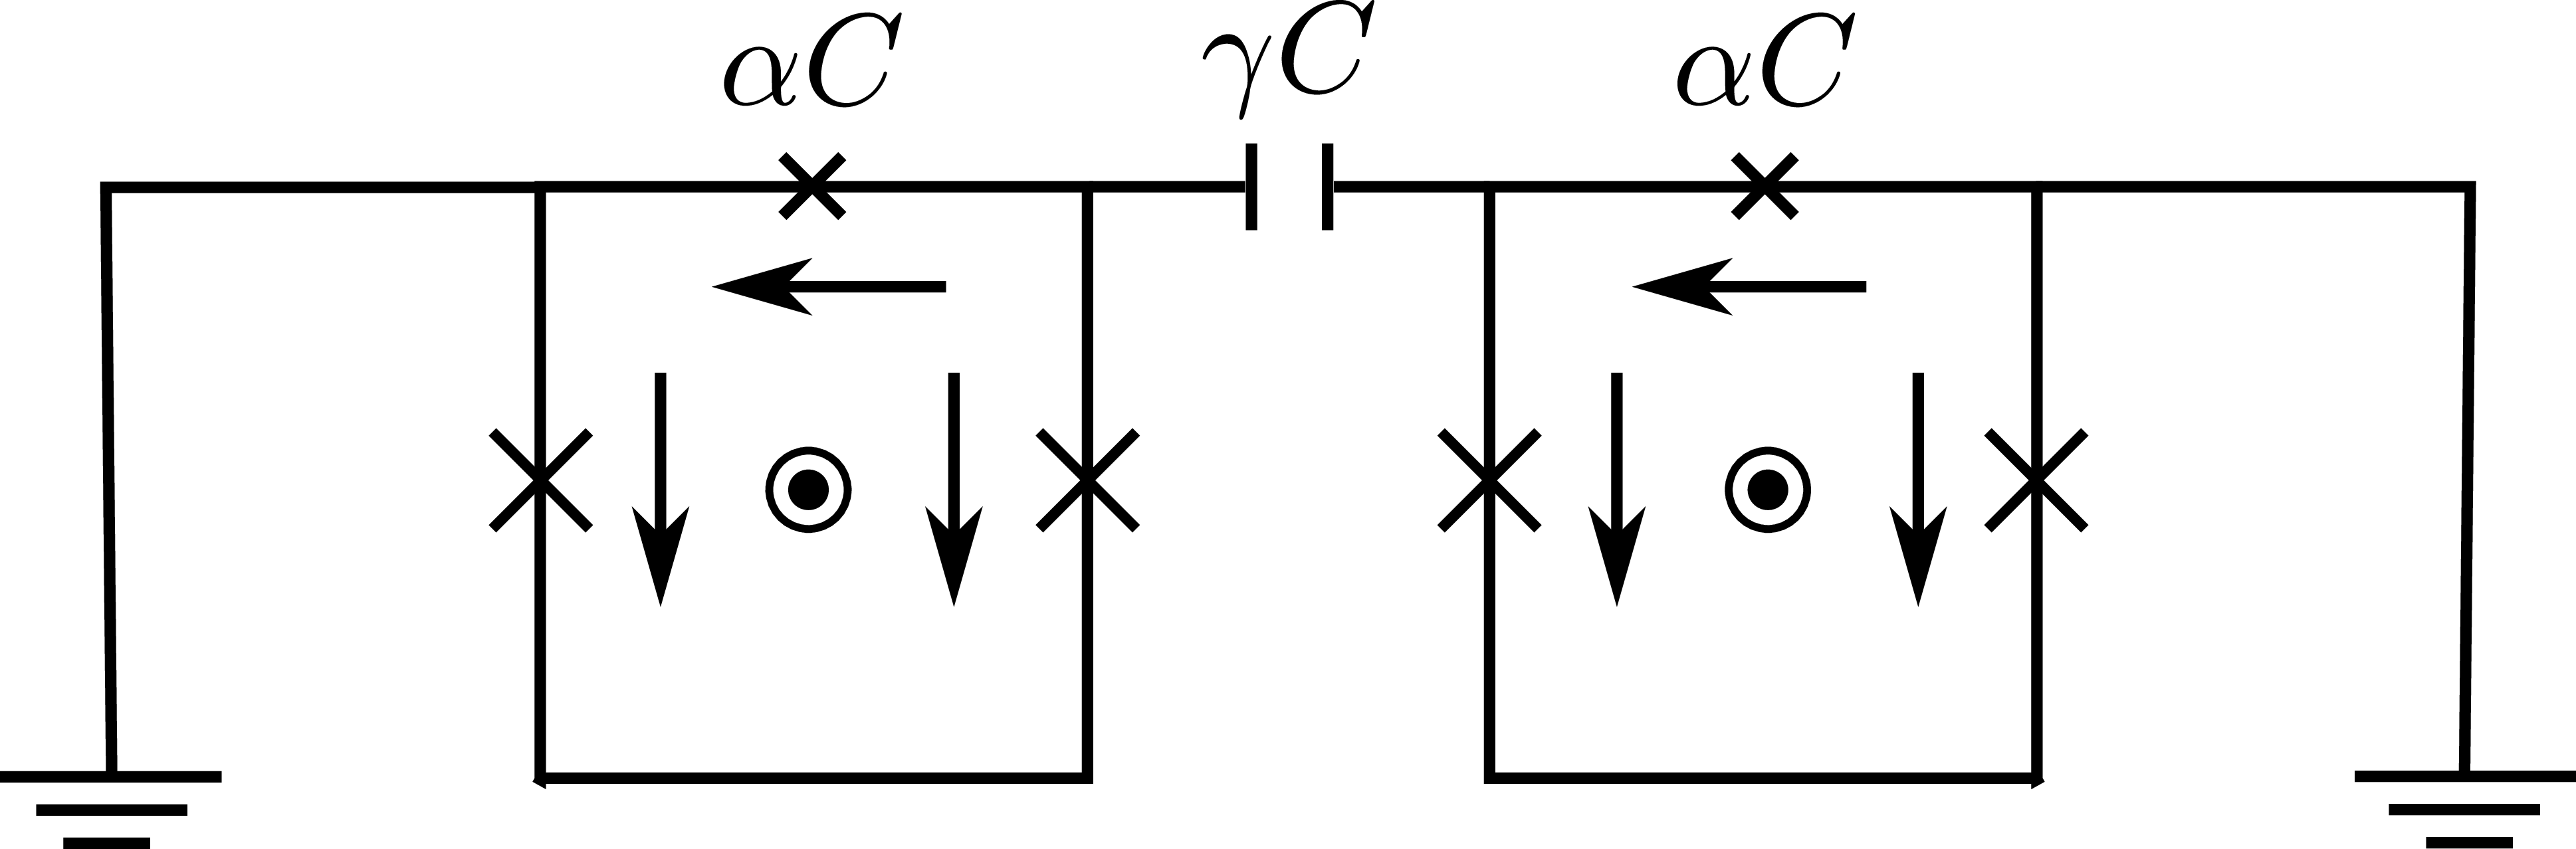

In [35]:
from IPython.display import Image
PATH = "./"
Image(filename = PATH + "Fig_coupled.png", width=1000, height=1000)

We work out the theory for two capacitatively coupled qubits as the one depiecter above. The variable of each qubit is $\varphi_{i,-}$, where $i=1,2$. The Hamiltonian of the system can be written as:

\begin{align}
\mathcal{H}=&  \frac{Q_+^2}{2m_+}+\frac{Q_-^2}{2m_-}+\mathcal{U}_{2}\\
\end{align}

where the new modes are a linear combination of each of the qubit degree of freedom:
\begin{align}
 \dot{\psi}_\pm &= \frac{1}{2} (\dot{\varphi}_{1-}\pm\dot{\varphi}_{2-})\\
 m_{\pm} &= 2M_+ (1+2\alpha+2\gamma\mp 2\gamma)
\end{align}
We can rewrite the Hamiltonian in the old degrees of freedom:
\begin{align}
\mathcal{H}=& \frac{1}{2\overline{M}_-} \left(P_{1-}^2+P_{2-}^2\right) 
+\mathcal{U}_2(\varphi_{1-},\varphi_{2-})+\Delta \mathcal{H}\label{Eq:H2}\\
 \Delta \mathcal{H} = &     \left(\frac{1}{m_+}-\frac{1}{m_-}\right) P_{1-}P_{2-}
\end{align}


The renormalized mass of each qubit is:

$$\overline{M}_-=m_{+}m_-/(m_++m_-)$$


Following this we settled the subroutine to compute the renormalized 1 qubit gap. To do so we employ the hramonic approximation so that:

In [36]:
# The following subroutine computes the renormalized gap for two qubit coupled capacitatively as in previous
# figure. It depends on a, alpha, g the coupling and EJ EC.
def ggaph(a, g, Ej, Ec):
    phi_s = lambda x: np.arccos(1/(2*x))
    M = 1/(4*Ec)*(1+2*a)*(1+2*a+4*g)/(1+2*a+2*g)
    sigma2 = np.sqrt(Ec/Ej)*np.sqrt((1+2*a+2*g)*a /((1+2*a)*(1+2*a+4*g)*(4*a**2-1)))
    gap = -2*np.exp(-phi_s(a)**2/(2*sigma2)) * ( 1/(8*sigma2*M) 
                                                *(1-phi_s(a)**2/(2*sigma2))
                                                -Ej*(2*np.exp(-sigma2/2)-a*np.exp(-2*sigma2)) )
    return gap

We will express this opeartor  in the base $|L>,|R>$, by using the harmonic approximation but with renormalized masses. Doing so, we find:
\begin{align}
 \Delta H =& \ g\ \sigma_1^y\sigma_2^y\\
 g=& \gamma\ \frac{2\varphi_\star^2 E_C}{\overline{\sigma}_-^4(1+2\alpha)(1+2\alpha+4\gamma)} e^{-\frac{\varphi_\star^2}{\overline{\sigma}_-^2}}
\end{align}
wherer the renormalized spread of the ground-state harmonic oscillator is:
\begin{align}
 \overline{\sigma}_-^2= \sqrt{\frac{(1+2\alpha+2\gamma)\alpha}{(1+2\alpha+4\gamma)(1+2\alpha)(4\alpha^2-1)}}\sqrt{\frac{E_C}{E_J}}
\end{align}

In [71]:
# The following subroutine computes the coupling for two qubit coupled capacitatively as in previous
# figure. It depends on a, alpha, g the coupling and EJ EC.
def gcoup(a, g, Ej, Ec):
    phi_s = lambda x: np.arccos(1/(2*x))
    M = 1/(4*Ec)*(1+2*a)*(1+2*a+4*g)/(1+2*a+2*g)
    sigma2 = np.sqrt(Ec/Ej)*np.sqrt((1+2*a+2*g)*a /((1+2*a)*(1+2*a+4*g)*(4*a**2-1)))
    gc = (2*g * phi_s(a)**2)/((sigma2)**2*(1+2*a+4*g)*(1+2*a))*np.exp(-phi_s(a)**2/(sigma2))
    return gc




Data from Maria program:
E_ma is the energy spectum of the coupled system. Equbit_ma is the qubit energy for the coupled system. To plot former data one should use gamma_E_ma which contains the gamma values for each data.
G_ma is the coupling. Erquibit_ma is the renormalized qubit energy. This is computed by separating the coupled hamiltonian in the degrees of freedom of each qubit plus interactions. The renormalized qubit energy is obtained by the diagonalization of the single qubit Hamiltonian. The former two data set should be pltted as a funticion of gammaG_ma.


In [74]:

E_ma = np.real(np.load('./energiesvsgamma/E.npy'))
Equbit_ma = np.real(np.load('./energiesvsgamma/Equbit.npy'))
gammaE_ma = np.real(np.load('./energiesvsgamma/gamma.npy'))
G_ma = np.real(np.load('./couplingvsgamma/Jxx.npy'))
Erqubit_ma = 2*np.real(np.load('./couplingvsgamma/Er.npy'))
gammaG_ma = np.real(np.load('./couplingvsgamma/gamma.npy'))

# E_ma = np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/energiesvsgamma/E.npy'))
# Equbit_ma = np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/energiesvsgamma/Equbit.npy'))
# gammaE_ma = np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/energiesvsgamma/gamma.npy'))
# G_ma = np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/couplingvsgamma/Jxx.npy'))
# Erqubit_ma = 2*np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/couplingvsgamma/Er.npy'))
# gammaG_ma = np.real(np.load('/home/pino/Nextcloud/Annealing/programas/210305diago_flux/maria_data/Ej80alpha08/couplingvsgamma/gamma.npy'))


# E_ma = np.real(np.load('./maria_data/ground_bottom/1capacitor/energiesvsgamma/E.npy'))
# Equbit_ma = np.real(np.load('./maria_data/ground_bottom/1capacitor/energiesvsgamma/Equbit.npy'))
# gammaE_ma = np.real(np.load('./maria_data/ground_bottom/1capacitor/energiesvsgamma/gamma.npy'))
# G_ma = np.real(np.load('./maria_data/ground_bottom/1capacitor/couplingvsgamma/Jxx.npy'))
# Erqubit_ma = 2*np.real(np.load('./maria_data/ground_bottom/1capacitor/couplingvsgamma/Er.npy'))
# gammaG_ma = np.real(np.load('./maria_data/ground_bottom/1capacitor/couplingvsgamma/gamma.npy'))

# E_ma = np.real(np.load('./maria_data/Ej80alpha08/energiesvsgamma/E.npy'))
# Equbit_ma = np.real(np.load('./maria_data/Ej80alpha08/energiesvsgamma/Equbit.npy'))
# gammaE_ma = np.real(np.load('./maria_data/Ej80alpha08/energiesvsgamma/gamma.npy'))
# G_ma = np.real(np.load('./maria_data/Ej80alpha08/couplingvsgamma/Jxx.npy'))
# Erqubit_ma = 2*np.real(np.load('./maria_data/Ej80alpha08/couplingvsgamma/Er.npy'))
# gammaG_ma = np.real(np.load('./maria_data/Ej80alpha08/couplingvsgamma/gamma.npy'))

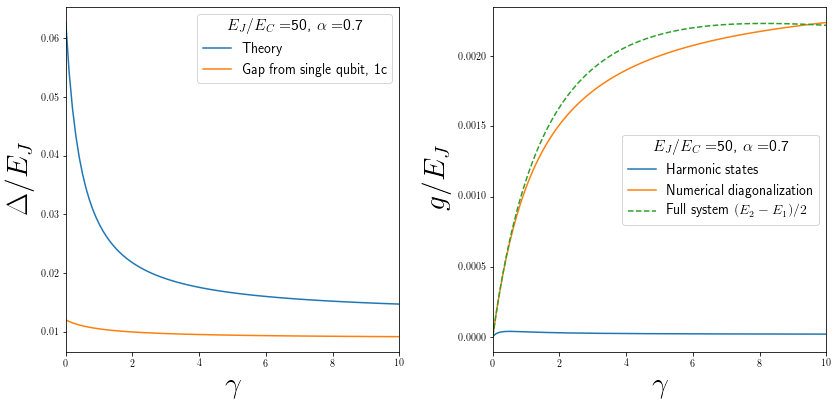

In [76]:
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

a = 0.7
m = 0.0
Ej = 50
Ec=1
xx = np.linspace(0.,10,100)
yh = np.array([ggaph(a, x, Ej, Ec) for x in xx]) 

ax1[0].plot(xx, yh/Ej, label = "Theory")
ax1[0].plot(gammaG_ma, -0.5*Erqubit_ma, label = "Gap from single qubit, 1c")
# ax1[0].plot(gammaG_ma, Equbit_ma[:,1]-Equbit_ma[:,0], label = "Renormalized gap $E_1-E_0$, 1c")



ax1[0].set_xlabel("$\\gamma$", fontsize=30)
ax1[0].set_ylabel("$\\Delta/E_J$", fontsize=30)
ax1[0].set_xlim([0., 10])
# ax1[0].set_ylim([0.01, 0.06])
ax1[0].legend(fontsize=14, title="$ E_J/E_C=$"+str(Ej)+", $\\alpha=$"+str(a), title_fontsize=16)
# ax1[0].legend(fontsize=11)


# ---------------------------------------

xx = np.linspace(0.,10,1000)
ygh = np.array([gcoup(a, x, Ej, Ec)/Ej for x in xx]) 


ax1[1].plot(xx, ygh, label = "Harmonic states")
ax1[1].plot(gammaG_ma, np.abs(G_ma), label = "Numerical diagonalization")
ax1[1].plot(gammaG_ma, 0.5*(E_ma[:,2]-E_ma[:,1]), "--",label = "Full system $(E_2-E_1)/2$")


ax1[1].set_xlabel("$\\gamma$", fontsize=30)
ax1[1].set_ylabel("$g/E_J$", fontsize=30)
ax1[1].set_xlim([0., 10])
ax1[1].legend(fontsize=14, title="$ E_J/E_C=$"+str(Ej)+", $\\alpha=$"+str(a), title_fontsize=16)

fig.tight_layout(pad=2.0)
plt.savefig("coupling_gap.pdf",bbox_inches='tight')
